In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')

# Load merged data
df = pd.read_csv('../data/merged_fuel_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
print(f"Loaded {len(df)} rows from {df['Date'].min()} to {df['Date'].max()}")

Loaded 5479 rows from 2010-01-01 00:00:00 to 2024-12-31 00:00:00


In [4]:
# Extract date components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

# Cyclical encoding for month (to capture seasonality)
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print("Time features created")

Time features created


In [5]:
# Define target columns
target_cols = ['LP_92', 'LP_95', 'LAD', 'LSD', 'LK']  

# Create lag features (1, 7, 30 days)
for target in target_cols:
    for lag in [1, 7, 30]:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)

# Create rolling statistics
for target in target_cols:
    for window in [7, 30]:
        df[f'{target}_rolling_mean_{window}'] = df[target].rolling(window=window).mean()
        df[f'{target}_rolling_std_{window}'] = df[target].rolling(window=window).std()

print("Lag and rolling features created for all 5 fuels")

Lag and rolling features created for all 5 fuels


In [6]:
# Crude Oil * Exchange Rate (import cost in LKR)
df['Crude_Oil_LKR'] = df['Crude_Oil_USD'] * df['Exchange Rate']

# Lagged crude oil (since price changes take time to reflect)
df['Crude_Oil_lag_7'] = df['Crude_Oil_USD'].shift(7)
df['Crude_Oil_lag_30'] = df['Crude_Oil_USD'].shift(30)

# Exchange rate rate of change
df['Exchange_Rate_pct_change'] = df['Exchange Rate'].pct_change() * 100

# Inflation * Exchange Rate (purchasing power impact)
df['Inflation_adj_factor'] = df['Inflation_Rate'] / 100 * df['Exchange Rate']

# Price change flags (for classification task)
for target in target_cols:
    df[f'{target}_change'] = df[target].diff()
    df[f'{target}_direction'] = np.sign(df[f'{target}_change'])
    df[f'{target}_increase_next'] = (df[target].shift(-1) > df[target]).astype(int)

print("Macroeconomic and Price change features created")

Macroeconomic and Price change features created


In [7]:
def is_sinhala_tamil_new_year(date):
    return (date.month == 4) and (date.day in [13, 14])

def is_vesak(date):
    return (date.month == 5) and (date.day >= 15 and date.day <= 25) 

def is_christmas(date):
    return (date.month == 12) and (date.day == 25)

def is_new_year(date):
    return (date.month == 1) and (date.day == 1)

df['Is_Sinhala_Tamil_New_Year'] = df['Date'].apply(is_sinhala_tamil_new_year).astype(int)
df['Is_Vesak'] = df['Date'].apply(is_vesak).astype(int)
df['Is_Christmas'] = df['Date'].apply(is_christmas).astype(int)
df['Is_New_Year'] = df['Date'].apply(is_new_year).astype(int)
df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Crisis Indicators
df['Is_COVID_Period'] = ((df['Date'] >= '2020-03-01') & (df['Date'] <= '2021-12-31')).astype(int)
df['Is_Crisis_2022'] = ((df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')).astype(int)
df['Is_Recovery_Period'] = (df['Date'] >= '2023-01-01').astype(int)

print("Holiday and Crisis indicators created")

Holiday and Crisis indicators created


In [8]:
# Check NaN counts
nan_counts = df.isnull().sum()
print("NaN counts before dropping:")
print(nan_counts[nan_counts > 0])

# Drop rows with NaN (from lag features)
df_clean = df.dropna().reset_index(drop=True)
print(f"\nShape after dropping NaN: {df_clean.shape}")
print(f"Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")

NaN counts before dropping:
LP_92_lag_1                  1
LP_92_lag_7                  7
LP_92_lag_30                30
LP_95_lag_1                  1
LP_95_lag_7                  7
LP_95_lag_30                30
LAD_lag_1                    1
LAD_lag_7                    7
LAD_lag_30                  30
LSD_lag_1                    1
LSD_lag_7                    7
LSD_lag_30                  30
LK_lag_1                     1
LK_lag_7                     7
LK_lag_30                   30
LP_92_rolling_mean_7         6
LP_92_rolling_std_7          6
LP_92_rolling_mean_30       29
LP_92_rolling_std_30        29
LP_95_rolling_mean_7         6
LP_95_rolling_std_7          6
LP_95_rolling_mean_30       29
LP_95_rolling_std_30        29
LAD_rolling_mean_7           6
LAD_rolling_std_7            6
LAD_rolling_mean_30         29
LAD_rolling_std_30          29
LSD_rolling_mean_7           6
LSD_rolling_std_7            6
LSD_rolling_mean_30         29
LSD_rolling_std_30          29
LK_rolling_

Features shape: (5449, 56)
Target shape: (5449, 5)


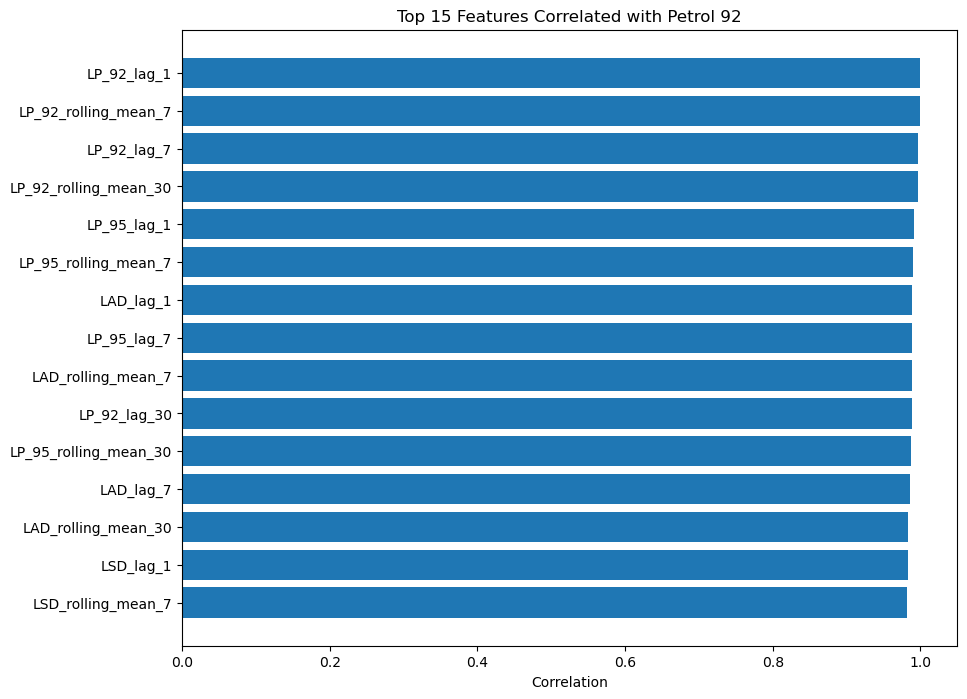

In [9]:
# Base features
feature_cols = [
    'Month', 'Month_Sin', 'Month_Cos', 'Quarter', 'Is_Weekend',
    'Crude_Oil_USD', 'Crude_Oil_lag_7', 'Crude_Oil_lag_30',
    'Exchange Rate', 'Exchange_Rate_pct_change', 'Crude_Oil_LKR',
    'GDP_Growth_Pct', 'Inflation_Rate', 'Inflation_adj_factor',
    'Is_Sinhala_Tamil_New_Year', 'Is_Vesak', 'Is_Christmas', 'Is_New_Year',
    'Is_COVID_Period', 'Is_Crisis_2022', 'Is_Recovery_Period'
]

# Dynamically add Lags and Rolling features for ALL 5 targets
target_cols = ['LP_92', 'LP_95', 'LAD', 'LSD', 'LK']
for target in target_cols:
    feature_cols.extend([f'{target}_lag_1', f'{target}_lag_7', f'{target}_lag_30'])
    feature_cols.extend([f'{target}_rolling_mean_7', f'{target}_rolling_std_7', f'{target}_rolling_mean_30', f'{target}_rolling_std_30'])

# Create feature matrix
X = df_clean[feature_cols]
y = df_clean[target_cols]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Correlation with Petrol 92 as a sample
corr_p92 = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': [df_clean[f].corr(df_clean['LP_92']) for f in feature_cols]
}).sort_values('Correlation', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(corr_p92['Feature'][:15], corr_p92['Correlation'][:15])
plt.xlabel('Correlation')
plt.title('Top 15 Features Correlated with Petrol 92')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.show()

In [10]:
import joblib
import os

# Identify numeric columns to scale (exclude binary/categorical)
binary_cols = ['Is_Weekend', 'Is_Sinhala_Tamil_New_Year', 'Is_Vesak', 
               'Is_Christmas', 'Is_New_Year', 'Is_COVID_Period', 
               'Is_Crisis_2022', 'Is_Recovery_Period']
cyclic_cols = ['Month_Sin', 'Month_Cos']

cols_to_scale = [col for col in feature_cols if col not in binary_cols and col not in cyclic_cols]

# Initialize and apply scaler
scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/feature_scaler.pkl')
joblib.dump(feature_cols, '../models/feature_names.pkl') # Save correct features

print("Features scaled and Scaler saved!")

Features scaled and Scaler saved!


In [11]:
# For time series, we must split chronologically
train_end = '2022-12-31'
val_end = '2023-09-30'

dates = df_clean['Date']

train_mask = dates <= train_end
val_mask = (dates > train_end) & (dates <= val_end)
test_mask = dates > val_end

# Apply masks
X_train = X_scaled[train_mask]
X_val = X_scaled[val_mask]
X_test = X_scaled[test_mask]
y_train = y[train_mask]
y_val = y[val_mask]
y_test = y[test_mask]

# Save final splits
os.makedirs('../feature_engineered_data', exist_ok=True)
X_train.to_csv('../feature_engineered_data/X_train.csv', index=False)
X_val.to_csv('../feature_engineered_data/X_val.csv', index=False)
X_test.to_csv('../feature_engineered_data/X_test.csv', index=False)
y_train.to_csv('../feature_engineered_data/y_train.csv', index=False)
y_val.to_csv('../feature_engineered_data/y_val.csv', index=False)
y_test.to_csv('../feature_engineered_data/y_test.csv', index=False)

print("\nData splits saved successfully!")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


Data splits saved successfully!
X_train shape: (4718, 56)
X_val shape: (273, 56)
X_test shape: (458, 56)
